In [12]:
function bit_reversing( n :: Int64 ) :: Float64
    
    k = 25        :: Int64
    miroir = 0.0  :: Float64
    deci = n      :: Int64
    
    if (deci > typemax(Int64))
       throw(ArgumentError(" n = $n is too big "))
    else
       while (k >= 0)
          div = 2^k
          if (deci÷div == 1)
             miroir += 2.0^(-k-1)
             deci = deci - div
          end
          k = k-1
       end
    end
    
    miroir

end

bit_reversing (generic function with 1 method)

In [13]:
[bit_reversing(k) for k in 0:10]

11-element Array{Float64,1}:
 0.0   
 0.5   
 0.25  
 0.75  
 0.125 
 0.625 
 0.375 
 0.875 
 0.0625
 0.5625
 0.3125

In [14]:
using Sobol

In [15]:
?Sobol.SobolSeq

No documentation found.

`Sobol.SobolSeq` is of type `UnionAll`.

# Summary

```
struct UnionAll <: Type{T}
```

# Fields

```
var  :: TypeVar
body :: Any
```

# Supertype Hierarchy

```
UnionAll <: Type{T} <: Any
```


In [16]:
s = SobolSeq(1)

1-dimensional Sobol sequence on [0,1]^1

In [17]:
[next!(s) for k = 0:10]

11-element Array{Array{Float64,1},1}:
 [0.5]   
 [0.75]  
 [0.25]  
 [0.375] 
 [0.875] 
 [0.625] 
 [0.125] 
 [0.1875]
 [0.6875]
 [0.9375]
 [0.4375]

In [18]:
function trinary_reversing( n :: Int64 ) :: Float64

    k = 16 :: Int64
    miroir = 0.0 :: Float64
    deci = n :: Int64
    
    if (deci > typemax(Int64))
       throw(ArgumentError(" n = $n is too big > 43046721=3^16 "))
    else
       while (k >= 0)
          div = 3^k
          if (deci÷div == 1)
             miroir += 3.0^(-k-1)
             deci = deci - div
          elseif (deci÷div == 2)
             miroir += 2 * 3.0^(-k-1)
             deci = deci - 2 * div
          end
          k = k-1
       end
    end
    
    miroir

end

trinary_reversing (generic function with 1 method)

In [19]:
[trinary_reversing(k) for k in 1:10]

10-element Array{Float64,1}:
 0.3333333333333333  
 0.6666666666666666  
 0.1111111111111111  
 0.4444444444444444  
 0.7777777777777777  
 0.2222222222222222  
 0.5555555555555556  
 0.8888888888888888  
 0.037037037037037035
 0.37037037037037035 

In [20]:
function penta_reversing( n :: Int64 ) :: Float64

    k = 11 :: Int64
    miroir = 0.0 :: Float64
    deci = n :: Int64
    
    if (deci > typemax(Int64)) then
       throw(ArgumentError(" n = $n is too big "))
    else
       while (k >= 0)
          div = 5^k
          if (deci÷div == 1) 
             miroir +=  5.0^(-k-1)
             deci = deci - div
          elseif (deci÷div == 2) 
             miroir +=  2 * 5.0^(-k-1)
             deci = deci - 2 * div
          elseif (deci÷div == 3) 
             miroir +=  3.0^(-k-1)
             deci = deci - 3 * div
          elseif (deci÷div == 4) 
             miroir += 4 * 5.0^(-k-1)
             deci = deci - 4 * div
          end
          k = k-1
       end
    end
    
    miroir

end

penta_reversing (generic function with 1 method)

In [21]:
[penta_reversing(k) for k in 1:10]

10-element Array{Float64,1}:
 0.2                
 0.4                
 0.3333333333333333 
 0.8                
 0.04               
 0.24000000000000002
 0.44               
 0.3733333333333333 
 0.8400000000000001 
 0.08               

In [22]:
function dichotomie(R)
    
    kx, alpha = 0.5, 0.1
    eps = 1e-12
    a, b = 0, 2π/kx
    while true
        x = 0.5 * (a+b)
        D = ( kx*x + alpha * sin(kx*x) ) / 2π
        if ( D<R-eps )
           a = x
        elseif ( D>R+eps )
           b = x
        else
           return x
        end
    end
end

dichotomie (generic function with 1 method)

In [23]:
dichotomie(0.9)

11.418335561725414

In [24]:
function plasma( nbpart :: Int64)

   vth    =  1.0   :: Float64
    
   xp = Float64[]
   vp = Float64[]

   for k=0:nbpart-1

      speed = vth * sqrt(-2 * log( (k+0.5)/nbpart))
        
      push!(xp,  dichotomie(bit_reversing( k )))
      push!(vp, speed * trinary_reversing( k ))

   end

   xp, vp
    
end

plasma (generic function with 1 method)

In [26]:
plasma(5)

([5.71452e-12, 6.28319, 2.94258, 9.62379, 1.43899], [0.0, 0.517252, 0.78494, 0.0938445, 0.204019])

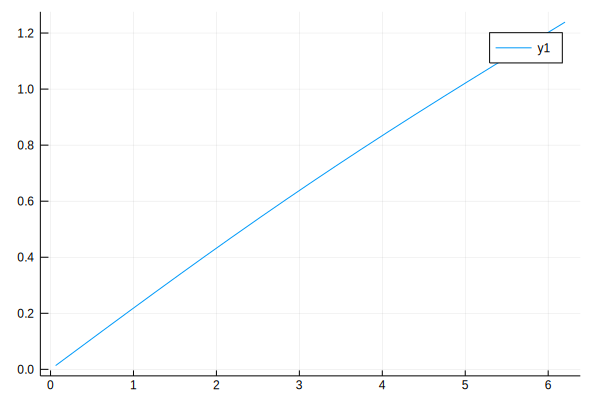

In [38]:
using Plots

function f(x) 
    alpha, kx  = 0.1, 0.5
    ( kx*x + alpha * sin(kx*x) ) / sqrt(2π)
end
plot(f, 0, 2π)